In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Stickyfy'
assert FOLDERNAME is not None, "[!] Enter the foldername."

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.models as model
import os
from PIL import Image
from matplotlib import image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import cv2
import h5py
%matplotlib inline
dtype = torch.cuda.FloatTensor
device = torch.device("cuda:0")

In [3]:
# Functions to pre process cartoon image
def remove_alpha(image, bg_color = (255,255,255)):
  if image.mode == 'RGBA':
    alpha = image.split()[-1]
    bg = Image.new("RGB", image.size, bg_color + (255,))
    bg.paste(image, mask=alpha)
    return bg
  else:
    return image
    
def preprocess(image):
  img_with_bg = remove_alpha(image)
  res_img = img_with_bg.resize((128,128))
  return res_img

class custom(object):
  def __call__(self, image):
    return remove_alpha(image)

In [4]:
class dataset_h5(torch.utils.data.Dataset):
  def __init__(self, in_file, transforms):
    super(dataset_h5, self).__init__()
    self.file = h5py.File(in_file, 'r')
    self.transform = transforms
    self.n_images = len((self.file).keys())

  def __getitem__(self, index):
      input = self.file['X'+str(index)][:,:,:]
      input = Image.fromarray(input)
      input = self.transform(input)
      return input

  def __len__(self):
      return self.n_images

In [5]:
img_transforms = transforms.Compose([
                                       custom(),
                                       transforms.Resize(128),
                                       transforms.ToTensor(),
])
cartoon_file = '/content/drive/My Drive/Stickyfy/cartoon_data.h5'
cartoon_dataset_h5 = dataset_h5(cartoon_file, img_transforms)
cartoon_loader = torch.utils.data.DataLoader(cartoon_dataset_h5, shuffle = True, batch_size = 10)
# face_file = '/content/drive/My Drive/Stickyfy/face_data.h5'
# face_dataset_h5 = dataset_h5(face_file, img_transforms)
# face_loader = torch.utils.data.DataLoader(face_dataset_h5, shuffle = True, batch_size = 512)

In [ ]:
cimg_dir = '/content/drive/My Drive/Stickyfy/Overfit/'
def cartoon_data_loader(data_dir, batch_size):
  img_transforms = transforms.Compose([
                                       custom(),
                                       transforms.Resize(128),
                                       transforms.ToTensor(),
  ])
  cartoon_data = datasets.ImageFolder(data_dir, transform = img_transforms)
  cartoon_loader = torch.utils.data.DataLoader(cartoon_data, batch_size = batch_size)
  return cartoon_loader
cartoon_loader = cartoon_data_loader(cimg_dir, 5)

In [6]:
class encoder_layers(nn.Module):
  def __init__(self, input_channels):
    super(encoder_layers, self).__init__()
    self.mu_fc = nn.Linear(input_channels,512)
    self.var_fc = nn.Linear(input_channels,512)
    self.relu = nn.ReLU()
  def forward(self, X):
    mu = self.mu_fc(X)
    var = self.var_fc(X)
    return (mu,var)

class Unflatten(nn.Module):
  def __init__(self,N,C,H,W):
    super(Unflatten, self).__init__()
    self.N = N
    self.W = W
    self.H = H
    self.C = C
  def forward(self,X):
    return X.view(self.N, self.C, self.H, self.W)


class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()
  def forward(self, x):
    N = x.shape[0]
    return x.view(N,-1)

def initialize_weights(m):
  if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight.data,0,1)
  
resnet34 = model.resnet34()
modules=list(resnet34.children())[:-2]
resnet34 = nn.Sequential(
    *modules,
    nn.AvgPool2d(kernel_size = 4, stride = 1)
)
initialize_weights(resnet34)
resnet34.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
def encoder_model(out_size):
  model = nn.Sequential(
      # Input is 128x128x3
      resnet34,
      # Input is 1x1x512
      Flatten(),
      nn.Linear(512,256)
  )
  return model

def decoder_model():
  model = nn.Sequential(
      nn.Linear(256, 1024),
      nn.Linear(1024,2048),
      Unflatten(-1, 512, 2, 2),
      # Input is 2x2x512
      nn.ConvTranspose2d(512,256,kernel_size = 8, stride = 4, padding = 2),
      nn.LeakyReLU(),
      nn.BatchNorm2d(256),
      nn.ConvTranspose2d(256,128,kernel_size = 8, stride = 4, padding = 2),
      nn.LeakyReLU(),
      nn.BatchNorm2d(128),
      # Input is 32x32x256
      nn.ConvTranspose2d(128,64,kernel_size = 8, stride = 4, padding = 2),
      nn.LeakyReLU(),
      nn.BatchNorm2d(64),
      nn.Conv2d(64,3, kernel_size = 3, padding = 1, stride = 1),
      nn.Tanh(),
  )
  return model

In [ ]:
def sample(mu, logvar, mode):
  std = 0.5 * torch.exp(logvar)
  temp = torch.randn_like(std)
  temp = temp.type(dtype)
  if mode == 'Training':
    z = mu + temp * std
  else:
    z = mu
  return z

In [ ]:
import time
import math
lr = 0.0005
def train_vae(encoder, decoder, data_loader, print_every = 5, num_epoch = 1, k = 0.1):
  global lr
  encode_optimizer = optim.Adam(encoder.parameters(), lr = lr, betas = (0.5, 0.999), weight_decay=0)
  decode_optimizer = optim.Adam(decoder.parameters(), lr = lr, betas = (0.5, 0.999), weight_decay=0)
  losses = []
  kl_losses = []
  rec_losses = []
  for i in np.arange(num_epoch):
    count = 0
    rec_loss = 0.0
    kl_loss = 0.0
    sum_loss = 0.0
    for batch,_ in data_loader:
      # print("Time for loading data = {}".format(time.time() - start_time))
      batch = batch.type(dtype)
      N = batch.shape[0]
      # start_time = time.time()
      count+=1
      # mu, logvar = encoder(batch)
      # z = sample(mu, logvar, 'Training')
      z = encoder(batch)
      f_image = decoder(z)
      loss = torch.mean(torch.square(f_image - batch))
      rec_loss += loss.item()
      # kl_loss = (0.5 * torch.mean(torch.mean(torch.square(mu) + torch.exp(logvar) - logvar - 1,1)))
      # loss = loss + k*kl_loss
      # kl_loss += kl_loss.item()
      sum_loss += loss.item()
      encoder.zero_grad()
      decoder.zero_grad()
      loss.backward()
      encode_optimizer.step()
      decode_optimizer.step()
      del batch
      # print("Time for opertaions = {}".format(time.time() - start_time))      
  return losses, kl_losses, rec_losses

In [ ]:
encoder = encoder_model(1*1*512)
decoder = decoder_model()
encoder.to(device)
decoder.to(device)
initialize_weights(encoder)
initialize_weights(decoder)
# torch.nn.utils.clip_grad_value_(encoder.parameters(), 10)
# torch.nn.utils.clip_grad_value_(decoder.parameters(), 10)

In [ ]:
loss, kl_loss, rec_loss = train_vae(encoder, decoder, cartoon_loader, print_every = 1, num_epoch = 200, k = 0.1)

In [ ]:
range = np.arange(40)
loss_t = []
for l in loss:
  loss_t.append(float(l))
plt.plot(range, loss_t)

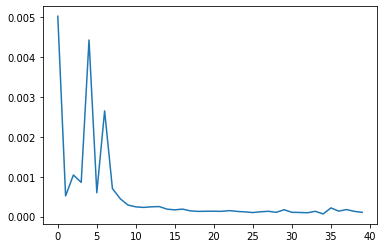

In [ ]:
range = np.arange(40)
loss_t = []
for l in kl_loss:
  loss_t.append(float(l))
plt.plot(range, loss_t)

In [ ]:
range = np.arange(40)
loss_t = []
for l in rec_loss:
  loss_t.append(float(l))
plt.plot(range, loss_t)

In [ ]:
# Test images loader
target_path = '/content/drive/My Drive/Stickyfy/Test_images/cropped_faces/'
def test_data_loader(data_dir):
  img_transforms = transforms.Compose([
                                       custom(),
                                       transforms.Resize((128,128)),
                                       transforms.ToTensor(),
  ])
  test_data = datasets.ImageFolder(data_dir, transform = img_transforms)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1)
  return test_loader

In [ ]:
# Final tests
test_loader = test_data_loader(target_path)
i = 0
with torch.no_grad():
  for image,_ in test_loader:
    trans = transforms.ToPILImage(mode='RGB')
    image = image.type(dtype)
    # mu, var = encoder(image)
    # z = sample(mu, var, 'Testing')
    z = encoder(image)
    # print(z)
    img2 = decoder(z)
    img2 = img2.to(torch.device('cpu'))
    img = trans(img2.squeeze())
    # r,g,b = img.split()
    # img = Image.merge('RGB', (b,g,r))
    plt.imshow(img)
    plt.show()
# mu_test = (torch.normal(0.,1., size = (1,1))).type(dtype)
# var_test = (torch.abs(torch.normal(0.,1., size = (1,1)))).type(dtype)
# z = sample(mu_test, var_test)
# img2 = decoder(z)
# img2 = img2.to(torch.device('cpu'))
# plt.imshow(trans(img2.squeeze()))
# plt.show()

In [ ]:
path = '/content/drive/My Drive/Stickyfy/Models/'
torch.save(encoder.state_dict(), path+'cartoon_encoder.pt')
torch.save(decoder.state_dict(), path+'cartoon_decoder.pt')